In [80]:
import numpy as np
import matplotlib.pyplot as plt

In [64]:
def fill_rec(mat, choices, choice_id, player_id):
    if player_id < 0 or choice_id < 0:
        return
    idx = [player_id] + choices
    if sum(choices) % player_id == 0:
        mat[*idx] = 1
    else:
        mat[*idx] = -0.5
    choices[choice_id] -= 1
    fill_rec(mat, choices, choice_id - 1, player_id)
    choices[choice_id] += 1
    fill_rec(mat, choices, choice_id, player_id - 1)
    mat[player_id]

In [174]:
T = 100000
n_choices = 3
n_players = 3
eta = 0.1
epsilon = 0.5
Nash = True
mixed = False
mixed_regret = False
update_method = 'oftrl'

if n_players == 2:
    M_row = np.array([[1,-1], [-1, 1]])
    M_col = np.array([[-1,1], [1, -1]])
# elif n_players == 3:
#     mat = np.zeros([n_players] + [n_choices] * n_players)
#     fill_rec(mat, n_players, n_choices)
#     for i in range(n_players):
#         for j in range(n_choices):
#             for k in range(n_choices):
#                 if i + j + k % 3 == i:
#                     mat[i, j, k] = 1
#                 else:
#                     mat[i, j, k] = -0.5
    

In [82]:
def get_utility(x,s):
    reward = np.zeros(n_players)
    reward_vector = np.zeros((n_players, n_choices))
    
    for i in range(n_players):
        if not mixed:
            strat = np.random.choice(np.arange(n_choices), p=x[i])
            s[i] = np.zeros(n_choices)
            s[i][strat] = 1
        else:
            s[i] = x[i]
    
    if n_players == 2:
        reward[0] = s[0] @ M_row @ s[1].T
        reward[1] = s[1] @ M_col @ s[0].T
        
        reward_vector[0] = M_row @ s[1].T
        reward_vector[1] = M_col @ s[0].T
    if n_players == 3:
        for i in range(n_choices):
            for j in range(n_choices):
                for k in range(n_choices):
                    for p in range(n_players):
                        if (i+j+k+p)%3 == 0:
                            reward_vector[p][i] += s[(p+1)%3][j]*s[(p+2)%3][k]
                        else:
                            reward_vector[p][i] += s[(p+1)%3][j]*s[(p+2)%3][k]*(-1/2)
        for p in range(n_players):
            if mixed_regret:
                reward[p] = x[p] @ reward_vector[p].T
            else:
                reward[p] = s[p] @ reward_vector[p].T
#     print(reward_vector)
    return reward, reward_vector

In [83]:
def update(U, u, t, i):
    if update_method == 'ftrl':
        U[i] = U[i] + u[t][i]
    elif update_method == 'oftrl':
        if t >= 1:
            U[i] = U[i] + 2*u[t][i] - u[t-1][i]
        else:
            U[i] = U[i] + u[t][i]

In [150]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def run(eta):
    probs = np.zeros((n_players, T, n_choices), dtype=float)
    total_rewards = np.zeros(n_players)
    x = np.full((n_players, n_choices), 1/n_choices, dtype=float)
    
    if n_players == 2:
        x[0] = [0.75, 0.25]
        x[1] = [0.6, 0.4]

        equilibrium = [0.5,0.5]
    elif n_players == 3:
        x[0] = [0.5, 0.25, 0.25]
        x[1] = [0.6, 0.15, 0.25]
        x[2] = [0.55, 0.25, 0.2]

        equilibrium = [1/3,1/3,1/3]
        
    npe = np.array(equilibrium)
    
    s = np.zeros((n_players, n_choices))
    regret = np.zeros((n_players, T))
    U = np.zeros((n_players, n_choices))
    u = np.zeros((T, n_players, n_choices))
    sum_u = np.zeros((n_players, n_choices))
    
    max_regret = np.zeros(T)
    prob_distance = np.zeros((n_players, T))
    
    for t in range(T):
        cur_rewards, u[t] = get_utility(x,s)
#         print(cur_rewards)
        sum_u += u[t]
        for i in range(n_players):
            total_rewards[i] += cur_rewards[i]
            update(U, u, t, i)
            if Nash:
                x[i] = equilibrium
            elif update_method == 'ftrl':
                x[i] *= np.exp(eta * u[t][i])
                x[i] /= x[i].sum()
            elif update_method == 'oftrl':
                x[i] *= np.exp(eta * 2 * u[t][i] - eta * u[t-1][i])
                x[i] /= x[i].sum()
#             print(x[i])
            probs[i, t] = x[i].copy()
            prob_distance[i,t] = np.linalg.norm(x[i] - npe)
        for i in range(n_players):
            best_in_hind = np.argmax(sum_u[i], axis=0)
            regret[i, t] = sum_u[i][best_in_hind] - total_rewards[i]
    
    max_regret = np.amax(regret,axis = 0)
    
    print(sum_u)
    print(total_rewards)
    
    return regret, probs, max_regret, prob_distance

[[-3.190e+02  1.010e+03 -6.910e+02]
 [ 1.565e+02  5.915e+02 -7.480e+02]
 [-3.415e+02  5.000e-01  3.410e+02]]


/Users/erana/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


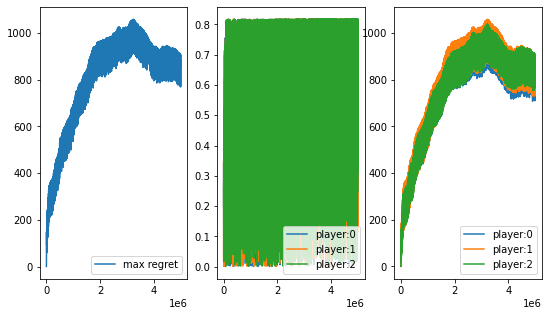

In [124]:
for eta in [0.01]:
    regret, probs, mr, pd = run(eta)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,5))
    legends = []
    
    ax1.plot(np.arange(T), mr, label='max regret')
    ax1.legend()
    
    for i in range(n_players):
        ax3.plot(np.arange(T), regret[i], label=f'player:{i}')
        ax3.legend()
        legends = f'player:{i}'
#         ax2.plot(np.arange(T), probs[i, :, 0], label=legends)
#         ax2.legend()
        ax2.plot(np.arange(T), pd[i, :], label=legends)
        ax2.legend()
    plt.show()

[[  8.5  41.5 -50. ]
 [-38.  -11.   49. ]
 [ -0.5  -0.5   1. ]]
[-141.5  112.    29.5]


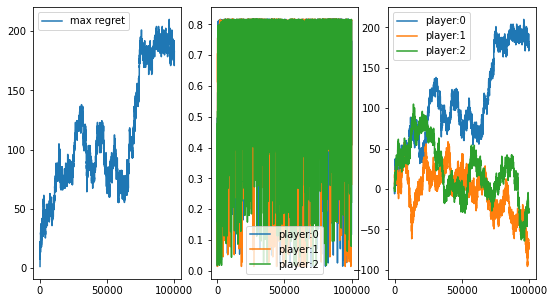

In [182]:
regret, probs, mr, pd = run(eta)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,5))
legends = []

ax1.plot(np.arange(T), mr, label='max regret')
ax1.legend()

for i in range(n_players):
    ax3.plot(np.arange(T), regret[i], label=f'player:{i}')
    ax3.legend()
    legends = f'player:{i}'
#     ax2.plot(np.arange(T), probs[i, :, 0], label=legends)
#     ax2.legend()
    ax2.plot(np.arange(T), pd[i, :], label=legends)
    ax2.legend()
plt.show()

[1.5 2.5 3.5 4.5 5.5 6.5 7.5]


In [180]:
x=np.array([[1/2,1/4,1/4],[1/2,1/4,1/4],[1/2,1/4,1/4]])
s= np.zeros([3,3])
get_utility(x,s)

(array([ 1. , -0.5, -0.5]),
 array([[ 1. , -0.5, -0.5],
        [ 1. , -0.5, -0.5],
        [ 1. , -0.5, -0.5]]))